# Boiling Point of Compounds
Based on:
 1. S.-Y. Kim, I. Jeon and S.-J. Kang, "Integrating Data Science and Machine Learning to Chemistry Education: Predicting Classification and Boiling Point of Compounds", J. Chem. Educ., 101, 1771–1776 (2024). [doi:10.1021/acs.jchemed.3c01040](doi.org/10.1021/acs.jchemed.3c01040)
 2. A. Géron, Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems, Third edition (2023) ISBN: 9781098125974


## Setup

In [ ]:
from pylab import *
import pandas as pd
import sklearn

In [ ]:
sklearn.set_config(display='diagram')

## Functions

In [ ]:
def plot_fun(bps, bp_predictions, t=None):
    plot(bps, bp_predictions,'o')
    plot(bps,bps)
    axis('square')
    xlabel('Boiling Point')
    ylabel('Predicted Boiling Point')
    title(t)
    show()

In [ ]:
def split_data_with_id_hash(data, test_ratio, id_column):

    from zlib import crc32

    def is_id_in_test_set(identifier, test_ratio):
      return crc32(np.int64(identifier)) < test_ratio * 2**32

    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

## Import data

In [ ]:
data_url = 'https://raw.githubusercontent.com/woldr001/AIChE_Workshop_MSU/refs/heads/main/boiling_point_data.csv'
compounds = pd.read_csv(data_url)
compounds.head()

## Training Set and Test Set

In [ ]:
compounds = compounds.reset_index()
train_set, test_set = split_data_with_id_hash(compounds, 0.2, "index")

In [ ]:
len(train_set), len(test_set)

## Data Exploration

### Histograms

In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_set.hist(bins=50, figsize=(12, 8))
tight_layout()
show()

### Correlations

In [ ]:
cols = ['BoilingPoint', 'mw', 'polararea', 'heavycnt',
       'hbondacc', 'C number', 'N number', 'O number',
       'Side chain number', 'Double bond number', 'Triple bond number']
corr_matrix = train_set[cols].corr()
corr_matrix

### Scatter Plot

In [ ]:
from pandas.plotting import scatter_matrix
cols = ['BoilingPoint', 'mw', 'polararea', 'heavycnt',
        'C number', 'N number', 'O number',
       'Side chain number', 'Double bond number',]
scatters = scatter_matrix(train_set[cols], figsize=(12, 8))
for axs in scatters:
    axs[0].yaxis.label.set_rotation(45)
show()

## Prepare for ML

### Define Labels
Here we'll use the boiling points as labels. We'll also drop that data from the training set so that it won't be used as a feature

In [ ]:
compounds=train_set.drop('BoilingPoint', axis=1)
bps = train_set['BoilingPoint'].copy()

### Encode Category Features
To make the text feature "Classify1" more quantitative, use **"One Hot" encoding**, which adds columns to the data set where a "1" in the correct column indicates the category of the molecule.

In [ ]:
compounds_category = compounds[["Classify1"]]
compounds_category.head(10)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
compounds_cat_1hot = cat_encoder.fit_transform(compounds_category)
compounds_cat_1hot[:10]

In [ ]:
cat_encoder.categories_

### Scale Numerical Features
Numerical features like MW often have to be modified for machine learning.  We'll use two common approaches:
 - `SimpleImputer` will be used to add missing values with the *average* of that feature. Note that there aren't any missing values here, so this step actually does nothing for this data.
 - `StandardScaler` changes the numerical range of all numerical features to between -1 and 1. This normalization is preferred for many models especially neural networks

### Create Pipelines
We'll put all of our feature prep in a pipeline. We'll start by making a numerical pipeline called `num_pipeline` that combines `SimpleImputer` and `StandardScaler`.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

num_pipeline

---
Then we make a similar pipeline for categories called `cat_pipeline` using `SimpleImputer` and `Standard Scaler`:

In [ ]:
cat_pipeline = make_pipeline(
  SimpleImputer(strategy="most_frequent"),
  OneHotEncoder(handle_unknown="ignore"))

cat_pipeline

---
Then we combine the numerical and category pipelines into a single pipeline called `preprocessing`.  Here we specify which numerical and category features to use.

In [ ]:
from sklearn.compose import ColumnTransformer

num_features = ['mw', 'polararea', 'heavycnt',
       'hbondacc', 'C number', 'N number', 'O number',
       'Side chain number', 'Double bond number', 'Triple bond number']

cat_features = ["Classify1"]

preprocessing = ColumnTransformer([
  ("num", num_pipeline, num_features),
  ("cat", cat_pipeline, cat_features),
])

preprocessing

--- 

This is what it looks like when we apply `preprocessing` to the data.

In [ ]:
compounds_prepared = preprocessing.fit_transform(compounds)
compounds_prepared

---
Even though this is just an array of numbers, we can still get our feature names back:

In [ ]:
preprocessing.get_feature_names_out()

## Linear Regression

a Linear Regression model obtains the best fit linear function of all numerical features according to the formula:

$$ \hat{y}=\theta_0+\theta_1 x_1+\theta_2 x_2+\cdots+\theta_n x_n $$

This model is mostly equivalent to linear least squares curve fitting approaches in MATLAB and `scipy`.


---
We combine `preprocessing` with `LinearRegression` into a new pipeline, `lin_reg`. Then we actually fit the data to `bps` using the `fit` method of our new pipeline.

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(compounds, bps)

---
Now we can predict boiling points! We apply the `predict` method of the pipeline to `compounds`, and compare the first five results:

In [ ]:
bp_predictions = lin_reg.predict(compounds)
bp_predictions[:5]

In [ ]:
bps.iloc[:5]

### Figure of Merit

To quantify these differences, we'll use the root-mean-squared error, or RMSE, defined by:
$$ \operatorname{RMSE}(\mathbf{X}, h)=\sqrt{\frac{1}{m} \sum_{i=1}^m\left(h\left(\mathbf{y}^{(i)}\right)-y_{pred}^{(i)}\right)^2} $$

where $m$ is the number of data points, $y$ is the training labels (`bps`) and $y_{pred}$ is the predicted labels (`bp_predictions`). 

In [ ]:
from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(bps, bp_predictions)
print(f'The RMSE error for the Linear Model is {lin_rmse:.2f} degrees')

### Comparison Plot

We can compare the labels and predictions by plotting. In this plot, an ideal fit has all of the blue dots on the orange line. Not a good look for the linear model.

In [ ]:
plot_fun(bps, bp_predictions, 'Linear Regression')

### Cross-Validation
We can test these results for *overfitting* by making temporary test sets with a portion of our training data. Here, we use 10% of the training data as a test set. We can actually do this 10 different times with different portions of the training data and then look at statistics.  

**If the RMSE of the full training set is much less than the average RMSE from cross-validation, we have overfitted our data.**

In [ ]:
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg, compounds, bps,
                            scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
lin_rmses

In [ ]:
pd.Series(lin_rmses).describe()

---
The linear model does not seem to overfit the data, but can we get a better fit?

## Decision Tree

A Decision Tree model determines result based on a series of decisions. Here is an example decision tree for a 1D model:

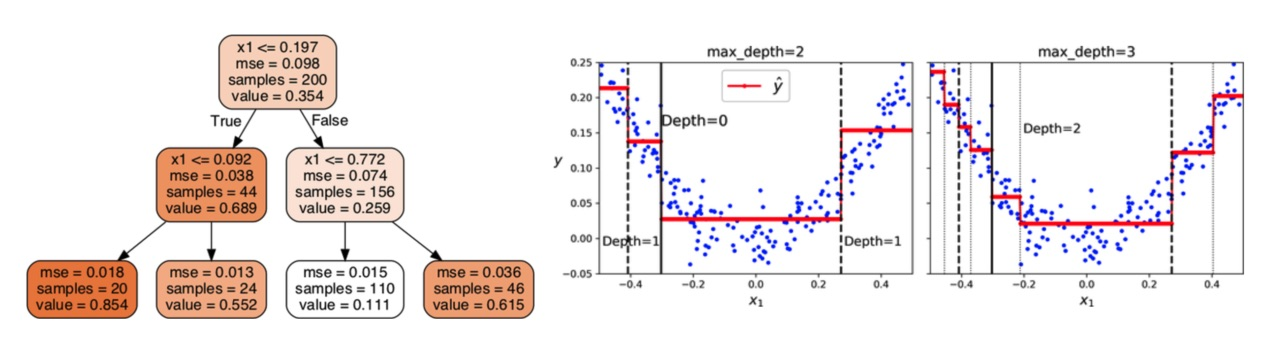

As can be seen, the more layers of decision tree that are included, the more predictions are possible and the better the fit.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(compounds, bps)

In [ ]:
bp_predictions = tree_reg.predict(compounds)
tree_rmse = root_mean_squared_error(bps, bp_predictions)
tree_rmse

In [ ]:
plot_fun(bps, bp_predictions, 'Decision Tree')

### Cross-Validation

In [ ]:
tree_rmses = -cross_val_score(tree_reg, compounds, bps,
                            scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
tree_rmses

In [ ]:
pd.Series(tree_rmses).describe()

---
Using the Decision Tree, the RMSE error for the entire training set is `13.3`, compared to an average of `39.2` for the cross-validation. This difference suggests that the Decision Tree model is *overfitted* and does not make good predictions.  Let's look at the depth and the number of leaves of our decision tree:

In [ ]:
depth = tree_reg[-1].get_depth()
n_leaves = tree_reg[-1].get_n_leaves()

print(f'The depth of the decision tree is {depth} \
and the number of leaves is {n_leaves}')

### Hyperparameter Tuning

The number of leaves is roughly a third of the training set size, which may be too large. Let's use `max_depth` as a *hyperparameter* to tune the model. 

In [ ]:
tree_reg = make_pipeline(preprocessing, 
                         DecisionTreeRegressor(max_depth=10,
                                               random_state=42))
tree_reg.fit(compounds, bps)

bp_predictions = tree_reg.predict(compounds)
tree_rmse = root_mean_squared_error(bps, bp_predictions)
tree_rmse

In [ ]:
tree_rmses = -cross_val_score(tree_reg, compounds, bps,
                            scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

In [ ]:
plot_fun(bps, bp_predictions, 'Decision Tree')

---
Changing `max_depth` from `17` to `10` does not have a huge effect. **You can explore other values!**

## Random Forest

The Random Forest model performs multiple decision tree analyses on a subset of features and then chooses the best result. The size of the subset is typically $\sqrt{n}$, where $n$ is the total number of features.  By compairing different subsets, the model can generate an indication of which features are most important.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                       RandomForestRegressor(max_depth = 10, random_state=42))
forest_reg

In [ ]:
forest_reg.fit(compounds, bps)

bp_predictions = forest_reg.predict(compounds)

forest_rmses = -cross_val_score(forest_reg, compounds, bps,
                            scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(forest_rmses).describe()

In [ ]:
plot_fun(bps, bp_predictions, 'Random Forest')

### Feature Importance

In [ ]:
feature_importances = forest_reg['randomforestregressor'].feature_importances_
feature_names = preprocessing.get_feature_names_out()

In [ ]:
barh(feature_names, feature_importances)
show()

---
Here we see that the molecular weight, `num_mw` is by far the most important feature. However, the polar area, carbon number and side chain number are also significant. The categories do not seem to be important at all.

**Try reducing the number of features in the pipeline to see what affect that has on the results.**

## Compare to Test Data

In [ ]:
test_bps = test_set['BoilingPoint'].copy()
test_predictions = forest_reg.predict(test_set)

In [ ]:
plot_fun(test_bps, test_predictions, 'Random Forest - Test Set')

In [ ]:
final_rmse = root_mean_squared_error(test_bps, test_predictions)
print(final_rmse)

---
Now we finally compare our result to the test data and see that the predictions are ok but not great. We are off to a good start, but this model certainly could use some improvement.

**What ideas do you have to improve this model, to the point that you would trust it for your work?**